In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
# Install OpenCV 4.5.3.56
!pip install  opencv-python==4.5.3.56
!pip install  opencv-contrib-python==4.5.3.56

In [ ]:
# Importing libraries
import cv2
import keras
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
import random
import requests
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix 
import time
from timeit import default_timer as timer
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [ ]:
# Check OpenCV version after import
print(cv2.__version__)

4.5.3


In [ ]:
# Specify the set of random numbers
np.random.seed(0)

In [ ]:
# Enable the inline ploting
%matplotlib inline

# **Classification Model - CNN**

## Load Data

In [ ]:
# Clone dataset from GitHub
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [ ]:
# Show what cloned dataset contains
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
# Split data into train, validate and test
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

# Split into inputs and outputs
x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

## Inspect Data

In [ ]:
# Check lenght of datasets
print(f"Lenght of train: {x_train.shape[0]}")
print(f"Lenght of validation: {x_val.shape[0]}")
print(f"Lenght of test: {x_test.shape[0]}")

Lenght of train: 34799
Lenght of validation: 4410
Lenght of test: 12630


In [ ]:
# Check if the number of inputs is the same as the number of outputs
assert(x_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(x_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(x_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"

# Check if shape of data is correct
assert(x_train.shape[1:] == (32, 32, 3)), "The dimension of the images are not 32 x 32 x 3"
assert(x_val.shape[1:] == (32, 32, 3)), "The dimension of the images are not 32 x 32 x 3"
assert(x_test.shape[1:] == (32, 32, 3)), "The dimension of the images are not 32 x 32 x 3"

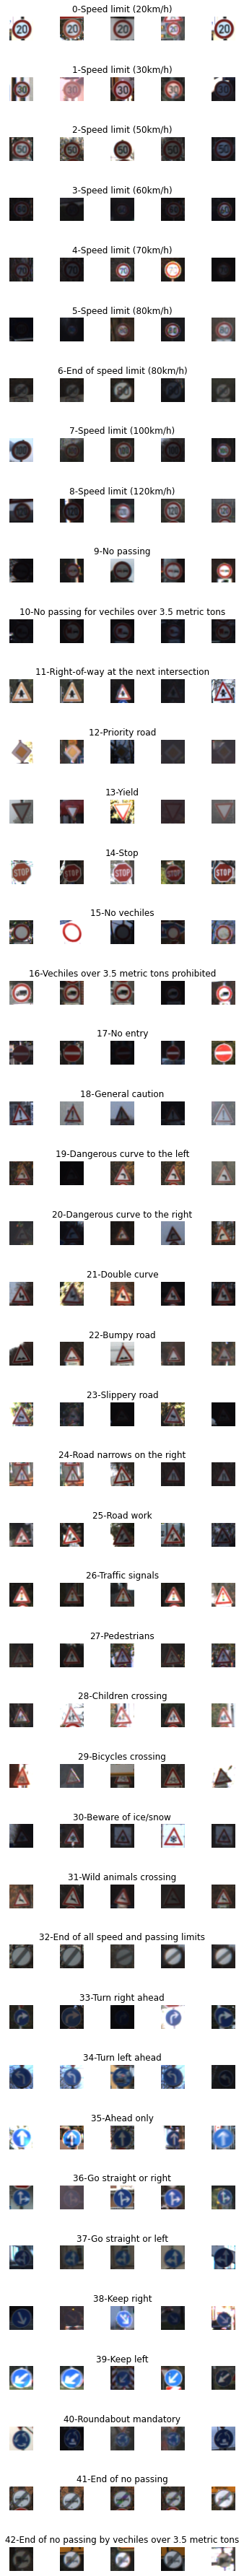

In [ ]:
# Load names of traffic sign categories
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43

# Display 5 random images per each category of traffic signs
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

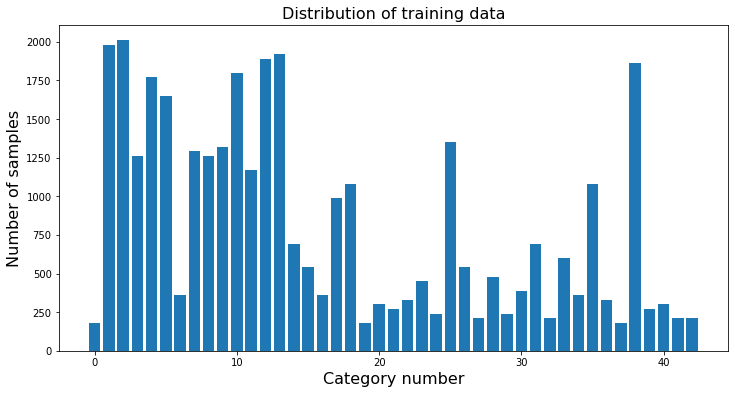

In [ ]:
# Plot number of samples per category of traffic signs
plt.figure(figsize=(12, 6))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of training data", fontsize=16)
plt.xlabel("Category number", fontsize=16)
plt.ylabel("Number of samples", fontsize=16)
plt.show()

## Image Processing

Image shape: (32, 32, 3)
Category number: 36



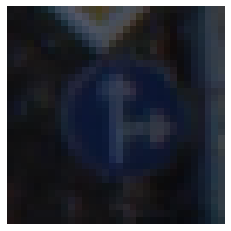

In [ ]:
# Display random image from the dataset
plt.imshow(x_train[1000])
plt.axis("off")
print(f"Image shape: {x_train[1000].shape}")
print(f"Category number: {y_train[1000]}\n")

Shape after grayscale: (32, 32)



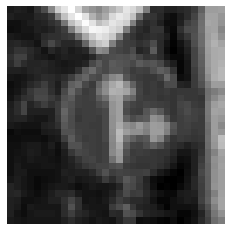

In [ ]:
# Convert the randomly selected image to grayscale
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(x_train[1000])
plt.imshow(img, cmap='gray')
plt.axis("off")
print(f"Shape after grayscale: {img.shape}\n")

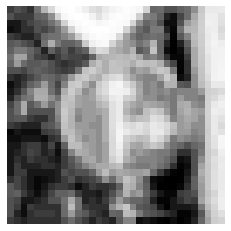

In [ ]:
# Perform histogram equalization on the randomly selected image
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
# Perform grayscale conversion, histogram equalization and normalization on the whole dataset
def preporocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

x_train = np.array(list(map( preporocessing, x_train)))
x_val = np.array(list(map( preporocessing, x_val)))
x_test = np.array(list(map( preporocessing, x_test)))

Shape of training dataset: (34799, 32, 32)



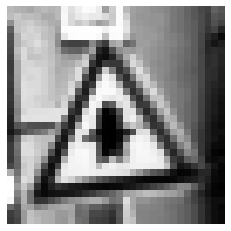

In [ ]:
# Random image from the dataset after image processing
plt.imshow(x_train[random.randint(0, len(x_train) - 1)], cmap='gray')
plt.axis("off")
print(f"Shape of training dataset: {x_train.shape}\n")

In [ ]:
# Reshape data to have depth of one (grayscale)
x_train = x_train.reshape(34799, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)

In [ ]:
# Perform image augmentation on training dataset
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
datagen.fit(x_train)

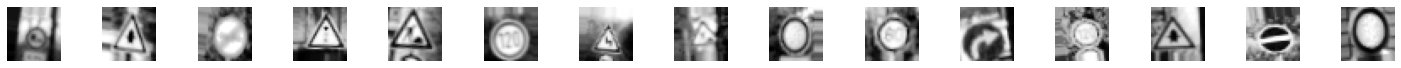

In [ ]:
# Split training dataset into smaller chunks 
batches = datagen.flow(x_train, y_train, batch_size=256)
x_batch, y_batch = next(batches)

# Plot sample of images after augmentation
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(x_batch[i].reshape(32, 32), cmap='gray')
  axs[i].axis('off')

In [ ]:
# Convert classes to categorical vectors
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

## Create Classification Model

In [ ]:
# Create model - Deep Convolutional Neural Network
def modified_model():
  model = Sequential()
  model.add(Conv2D(32, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(32, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (5, 5), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))

  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
# Model representation
model = modified_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 64)          51264     
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 64)          36928     
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Training the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=20, validation_data=(x_val, y_val), shuffle = 1)

Epoch 1/20
544/544 [==============================] - 14s 22ms/step - loss: 2.3774 - accuracy: 0.3273 - val_loss: 0.7798 - val_accuracy: 0.7481
Epoch 2/20
544/544 [==============================] - 12s 22ms/step - loss: 0.8788 - accuracy: 0.7270 - val_loss: 0.2067 - val_accuracy: 0.9358
Epoch 3/20
544/544 [==============================] - 12s 21ms/step - loss: 0.4859 - accuracy: 0.8476 - val_loss: 0.1092 - val_accuracy: 0.9626
Epoch 4/20
544/544 [==============================] - 12s 22ms/step - loss: 0.3511 - accuracy: 0.8937 - val_loss: 0.0832 - val_accuracy: 0.9732
Epoch 5/20
544/544 [==============================] - 12s 21ms/step - loss: 0.2827 - accuracy: 0.9134 - val_loss: 0.0492 - val_accuracy: 0.9844
Epoch 6/20
544/544 [==============================] - 13s 23ms/step - loss: 0.2380 - accuracy: 0.9294 - val_loss: 0.0593 - val_accuracy: 0.9819
Epoch 7/20
544/544 [==============================] - 12s 21ms/step - loss: 0.2083 - accuracy: 0.9373 - val_loss: 0.0287 - val_accuracy:

## Training Results

In [ ]:
# Load the best performing model
best_model = load_model('/content/drive/MyDrive/TSRC/CNN/my_best_dnn.keras')

In [ ]:
# Load the names of traffic signs (in Croatian)
labelNames = open("/content/drive/MyDrive/TSRC/CNN/signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

# Evaluate the best performing model
print("[INFO] evaluating network...")
predictions = best_model.predict(x_val, batch_size=64)
print(classification_report(y_val.argmax(axis=1),	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
                                                 precision    recall  f1-score   support

                    Ogranicenje brzine (20km/h)       1.00      1.00      1.00        30
                    Ogranicenje brzine (30km/h)       0.99      1.00      0.99       240
                    Ogranicenje brzine (50km/h)       1.00      1.00      1.00       240
                    Ogranicenje brzine (60km/h)       0.98      1.00      0.99       150
                    Ogranicenje brzine (70km/h)       0.99      1.00      1.00       210
                    Ogranicenje brzine (80km/h)       1.00      0.97      0.99       210
           Prestanak ogranicenja brzine(80km/h)       0.98      1.00      0.99        60
                   Ogranicenje brzine (100km/h)       0.99      1.00      1.00       150
                   Ogranicenje brzine (120km/h)       1.00      0.99      0.99       150
                            Zabrana pretjecanja       1.00      1.00      1.00  

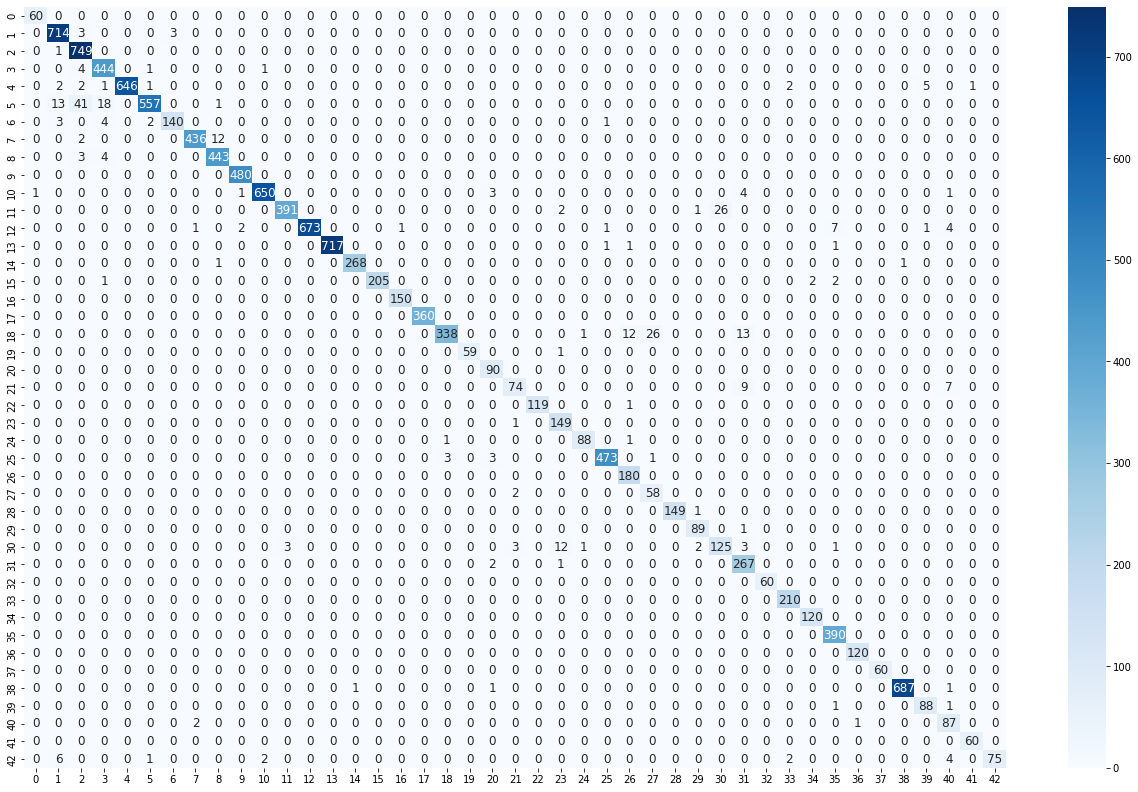

In [ ]:
# Create confusion matrix for the best performing model
y_pred=best_model.predict(x_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix for the best performing model
plt.figure(figsize = (22, 14))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', annot_kws={'size':12})
plt.show()

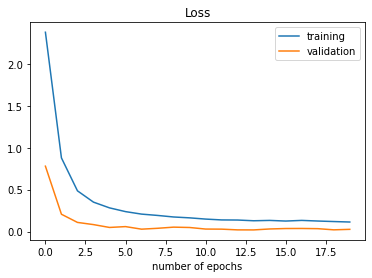

In [ ]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('number of epochs')
plt.show()

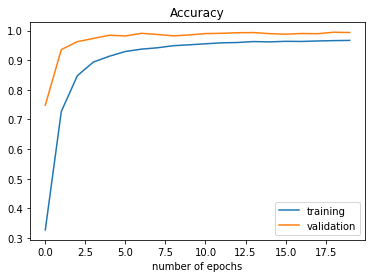

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('number of epochs')
plt.show()

In [ ]:
# Score of the best performing model
score = best_model.evaluate(x_test, y_test, verbose=0)

print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 0.12305701524019241
Test Accuracy: 0.9737133979797363


## Test Classification Model

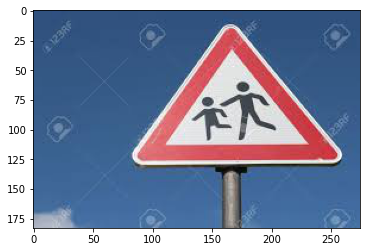

In [ ]:
# Examples of traffic signs for testing the model
#url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg' #speed limit 30 [1]
#url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg' #must turn left [34]
#url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg' #slippery road [23]
#url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg' #yield [13]
#url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg' #bicycle crossing [29]
#url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRqrfBCIB2iuquMh_aBYVBOB5U5zBbBEwRWlQ&usqp=CAU' #roadwork [25]
#url = 'https://miro.medium.com/max/734/1*m3L5X3ic_VMwQH1NTdZ1FA.png' #bumpy road [22]
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTfYwEafxFmV3vrRgNcra-PB5xX3qmnFFAIUA&usqp=CAU' #children crossing [28]

# Load an image
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img)
plt.show()

Shape after preprocessing: (32, 32)



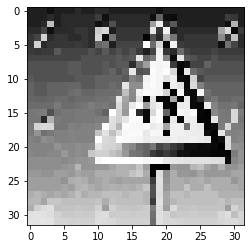

In [ ]:
#Preprocess the image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preporocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(f"Shape after preprocessing: {img.shape}\n")

In [ ]:
#Reshape the image
img = img.reshape(1, 32, 32, 1)

In [ ]:
#Test model on the image
print("Category number of predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))

Category number of predicted sign: [28]


## Save Model

In [ ]:
# Saving model and weights
# model.save('/content/drive/MyDrive/TSRC/CNN/my_best_dnn.keras')
# model.save_weights('/content/drive/MyDrive/TSRC/CNN/my_best_dnn.h5')

# **Detection Model - YOLOv4**

In [ ]:
# Change working directory to darknet
%cd '/content/drive/MyDrive/TSRC/darknet'

/content/drive/MyDrive/TSRC/darknet


In [ ]:
# Add permission to execute files in darknet folder
!chmod +x ./darknet

In [ ]:
# Train YOLO
!./darknet detector demo cfg/ts_data.data cfg/yolov4_tsb_test.cfg /content/drive/MyDrive/TSRC/darknet/backup/yolov4_tsb_train_best.weights /content/drive/MyDrive/Snimke/FInal_cuts/010040C03.mp4 -thresh 0.5 -out_filename results_hrv11.avi -dont_show

In [ ]:
# Load weights
path_to_weights = '/content/drive/MyDrive/TSRC/darknet/backup/yolov4_tsb_train_best.weights'
# Load configuration file
path_to_cfg = '/content/drive/MyDrive/TSRC/darknet/cfg/yolov4_tsb_test.cfg'

# Load weights and configuration file into the network
network = cv2.dnn.readNetFromDarknet(path_to_cfg, path_to_weights)

# To use with GPU
network.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV) #OPENCV
network.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL_FP16) #OPENCL_FP16

In [ ]:
# Get names of all YOLO v4 layers
layers_all = network.getLayerNames()

# Get only detection layers
layers_names_output = [layers_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]

#**Recognition of Traffic Signs in Video File**

In [ ]:
# Load file with the names of traffic signs
labels = pd.read_csv('/content/drive/MyDrive/TSRC/CNN/signnames.csv')

In [ ]:
# Minimum probability to eliminate weak detections
probability_minimum = 0.6

# Set threshold to filter weak bounding boxes by non-maximum suppression
threshold = 0.4

# Generate colours for bounding boxes
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

In [ ]:
# Load video from a file
video = cv2.VideoCapture('/content/drive/MyDrive/Snimke/Final_cuts/030043C02.mp4')

# Writer that will be used to write processed frames
writer = None

# Variables for spatial dimensions of the frames
h, w = None, None

In [ ]:
# Set default size of plots
plt.rcParams['figure.figsize'] = (3, 3)

# Variable for counting total amount of frames
f = 0

# Variable for counting total processing time
t = 0

# Catch frames in the loop
while True:
    # Capture frames one-by-one
    ret, frame = video.read()

    # If the frame was not retrieved
    if not ret:
        break
       
    # Get spatial dimensions of the frame for the first time
    if w is None or h is None:
        # Slice two elements from tuple
        h, w = frame.shape[:2]

    # Blob from current frame
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (800, 800), swapRB=True, crop=False)

    # Forward pass with blob through output layers
    network.setInput(blob)
    start = time.time()
    output_from_network = network.forward(layers_names_output)
    end = time.time()

    # Increase counters
    f += 1
    t += end - start

    # Spent time for current frame
    print('Frame number {0} took {1:.5f} seconds'.format(f, end - start))

    # Lists for detected bounding boxes, confidences and class's number
    bounding_boxes = []
    confidences = []
    class_numbers = []

    # Go through all output layers after feed forward pass
    for result in output_from_network:
        # Go through all detections from current output layer
        for detected_objects in result:
            # Get 80 classes probabilities for current detected object
            scores = detected_objects[5:]
            # Get index of the class with the maximum value of probability
            class_current = np.argmax(scores)
            # Get value of probability for defined class
            confidence_current = scores[class_current]

            # Eliminate weak predictions by minimum probability
            if confidence_current > probability_minimum:
                # Scale bounding box coordinates to the initial frame size
                box_current = detected_objects[0:4] * np.array([w, h, w, h])

                # Get top left corner coordinates
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                # Add results into prepared lists
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)
                

    # Implement non-maximum suppression of given bounding boxes
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    # Check if there is any detected object been left
    if len(results) > 0:
        # Go through indexes of results
        for i in results.flatten():
            # Bounding box coordinates (width and height)
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
                        
            # Cut fragment with traffic sign
            c_ts = frame[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
                       
            if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
                pass
            else:

                # Preprocess cut out fragments
                c_ts = np.asarray(c_ts)
                c_ts = cv2.resize(c_ts, (32, 32))
                c_ts = preporocessing(c_ts)
                c_ts = c_ts.reshape(1, 32, 32, 1)

                # Feed to the Clasification model to get predicted label among 43 classes
                scores = best_model.predict(c_ts)

                # Get only class with max confidence
                prediction = np.argmax(scores)

                # Color for current bounding box
                color_box_current = colours[class_numbers[i]].tolist()

                # Draw bounding box on the original current frame
                cv2.rectangle(frame, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              color_box_current, 2)

                # Prepare text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction], confidences[i])

                # Put text with label and confidence on the original image
                cv2.putText(frame, text_box_current, (x_min, y_min - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_box_current, 2)


    # Initialize writer only once
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')

        # Writing current processed frame into the video file
        writer = cv2.VideoWriter('/content/drive/MyDrive/TSRC/res_hrv_030043C02.mp4', fourcc, 25,
                                 (frame.shape[1], frame.shape[0]), True)

    # Write processed current frame to the file
    writer.write(frame)


# Release video reader and writer
video.release()
writer.release()